# VDS2425 Project: Team Improvement Analysis

Here we analyze Which teams have improved the most in recent years with the help of our provided dataset.

"author: TANJIM HOSSAIN"
"ID: 2469700"

In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import os

# data path
DATA_DIR = '/Users/tanjimhossain/Documents/Visualisation DS/VS_Final-project/VDS2425 Football'

# Load data
matches = pd.read_csv(os.path.join(DATA_DIR, 'Match.csv'))
teams = pd.read_csv(os.path.join(DATA_DIR, 'Team.csv'))
leagues = pd.read_csv(os.path.join(DATA_DIR, 'League.csv'))

# Extract season year
matches['season_start'] = matches['season'].str[:4].astype(int)
print('Available seasons in Match.csv:', matches['season_start'].unique())


Available seasons in Match.csv: [2008 2009 2010 2011 2012 2013 2014 2015]


## Compute Results for Each Team

In [4]:

def result(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return row['home_team_api_id'], 'win', row['away_team_api_id'], 'loss'
    elif row['home_team_goal'] < row['away_team_goal']:
        return row['home_team_api_id'], 'loss', row['away_team_api_id'], 'win'
    else:
        return row['home_team_api_id'], 'draw', row['away_team_api_id'], 'draw'

records = []
for _, r in matches.iterrows():
    h_id, h_res, a_id, a_res = result(r)
    records.append((h_id, h_res, r['season_start'], r['league_id']))
    records.append((a_id, a_res, r['season_start'], r['league_id']))

team_results = pd.DataFrame(records, columns=['team_api_id','result','season_start','league_id'])
print('Sample of team_results DataFrame:')
print(team_results.head())


Sample of team_results DataFrame:
   team_api_id result  season_start  league_id
0         9987   draw          2008          1
1         9993   draw          2008          1
2        10000   draw          2008          1
3         9994   draw          2008          1
4         9984   loss          2008          1


## Calculate Win Percentage by Team and Season

In [5]:

summary = team_results.groupby(['team_api_id','season_start','league_id']).result.value_counts().unstack(fill_value=0)
summary['matches'] = summary.sum(axis=1)
summary['win_pct'] = summary.get('win', 0) / summary['matches'] * 100
summary = summary.reset_index()

# Map names
summary = summary.merge(teams[['team_api_id','team_long_name']], on='team_api_id')
summary = summary.merge(leagues[['id','name']], left_on='league_id', right_on='id')
summary.rename(columns={'team_long_name':'Team','name':'League'}, inplace=True)

print('Summary table columns:', summary.columns)
print('Sample summary table:')
print(summary.head())


Summary table columns: Index(['team_api_id', 'season_start', 'league_id', 'draw', 'loss', 'win',
       'matches', 'win_pct', 'Team', 'id', 'League'],
      dtype='object')
Sample summary table:
   team_api_id  season_start  league_id  draw  loss  win  matches    win_pct  \
0         1601          2008      15722     7    14    9       30  30.000000   
1         1601          2009      15722     5     9   16       30  53.333333   
2         1601          2010      15722     8    12   10       30  33.333333   
3         1601          2011      15722     7     7   16       30  53.333333   
4         1601          2012      15722     7    15    8       30  26.666667   

           Team     id              League  
0  Ruch Chorzów  15722  Poland Ekstraklasa  
1  Ruch Chorzów  15722  Poland Ekstraklasa  
2  Ruch Chorzów  15722  Poland Ekstraklasa  
3  Ruch Chorzów  15722  Poland Ekstraklasa  
4  Ruch Chorzów  15722  Poland Ekstraklasa  


## Create Pivot Table for Seasons

In [6]:

df_for_pivot = (
    summary[['team_api_id', 'Team', 'League', 'season_start', 'win_pct']]
    .drop_duplicates()
)

pivot = df_for_pivot.pivot_table(
    index=['team_api_id', 'Team', 'League'],
    columns='season_start',
    values='win_pct'
)

print('Pivot columns (seasons):', list(pivot.columns))
print('Pivot sample:')
print(pivot.head())


Pivot columns (seasons): [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Pivot sample:
season_start                                                     2008  \
team_api_id Team                  League                                
1601        Ruch Chorzów          Poland Ekstraklasa        30.000000   
1773        Oud-Heverlee Leuven   Belgium Jupiler League          NaN   
1957        Jagiellonia Białystok Poland Ekstraklasa        30.000000   
2033        S.C. Olhanense        Portugal Liga ZON Sagres        NaN   
2182        Lech Poznań           Poland Ekstraklasa        53.333333   

season_start                                                     2009  \
team_api_id Team                  League                                
1601        Ruch Chorzów          Poland Ekstraklasa        53.333333   
1773        Oud-Heverlee Leuven   Belgium Jupiler League          NaN   
1957        Jagiellonia Białystok Poland Ekstraklasa        36.666667   
2033        S.C. Olhanense        P

## Detect Available Seasons and Compute Net Win% Change

In [7]:

# Detect numeric columns (seasons)
season_cols = [c for c in pivot.columns if isinstance(c, int)]
print('Numeric season columns:', season_cols)

if len(season_cols) < 2:
    raise ValueError('Not enough seasons to compute net win percentage change!')

first_season = min(season_cols)
last_season = max(season_cols)

print(f'Using first_season={first_season}, last_season={last_season}')

pivot = pivot.dropna(subset=[first_season, last_season])
pivot['Net_WinPct_Change'] = pivot[last_season] - pivot[first_season]
pivot = pivot.reset_index()
print('Sample net change data:')
print(pivot[['Team','League','Net_WinPct_Change']].head())


Numeric season columns: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Using first_season=2008, last_season=2015
Sample net change data:
season_start                   Team                    League  \
0                      Ruch Chorzów        Poland Ekstraklasa   
1             Jagiellonia Białystok        Poland Ekstraklasa   
2                       Lech Poznań        Poland Ekstraklasa   
3                          Cracovia        Poland Ekstraklasa   
4              FC Paços de Ferreira  Portugal Liga ZON Sagres   

season_start  Net_WinPct_Change  
0                      6.666667  
1                      3.333333  
2                    -10.000000  
3                     16.666667  
4                      8.235294  


## All Team Win Percentage Improvement by Season (2008–2016)

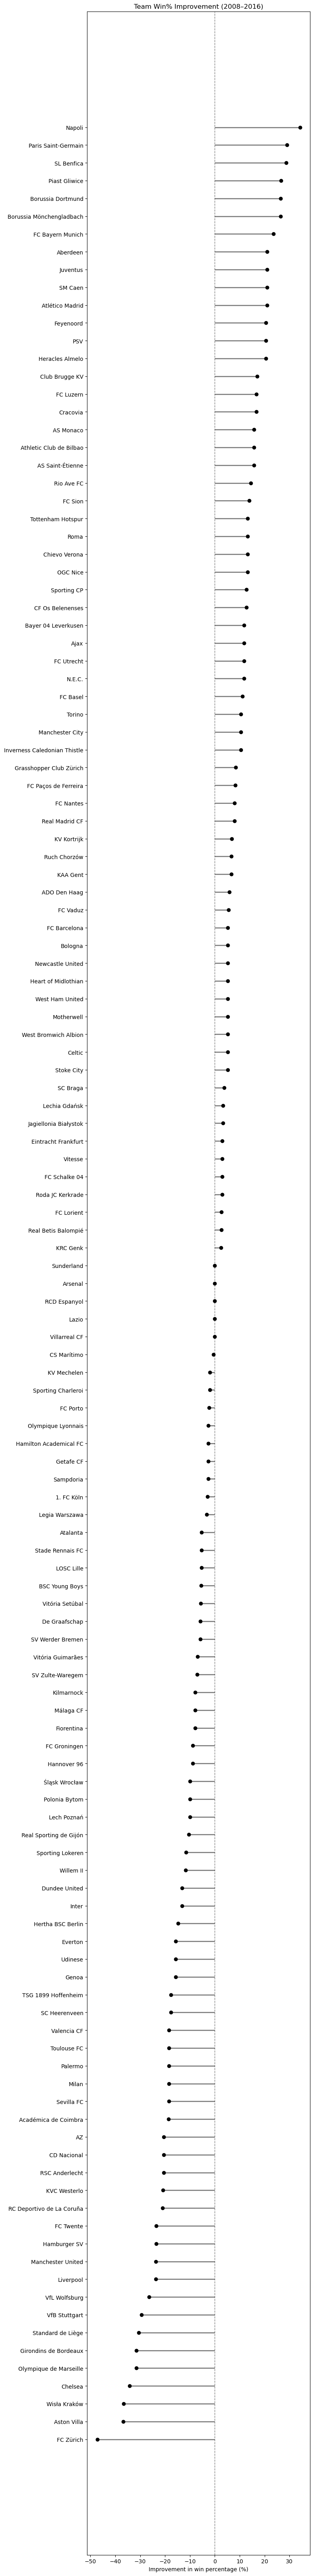

In [8]:
# Sort by lowest to highest
pivot_sorted = pivot.sort_values('Net_WinPct_Change')

teams = pivot_sorted['Team'].tolist()
improvement = pivot_sorted['Net_WinPct_Change'].tolist()

plt.figure(figsize=(8, max(5, int(len(teams) * 0.5))))  # Dynamic height for many teams
plt.hlines(y=teams, xmin=0, xmax=improvement, color='gray', lw=2)
plt.plot(improvement, teams, 'o', color='black')
plt.xlabel('Improvement in win percentage (%)')
plt.title('Team Win% Improvement (2008–2016)')  # even if last year is 2015
plt.axvline(0, color='black', lw=1, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Win Percentage Change: Top 10 Improvers and Decliners (2008–2016)

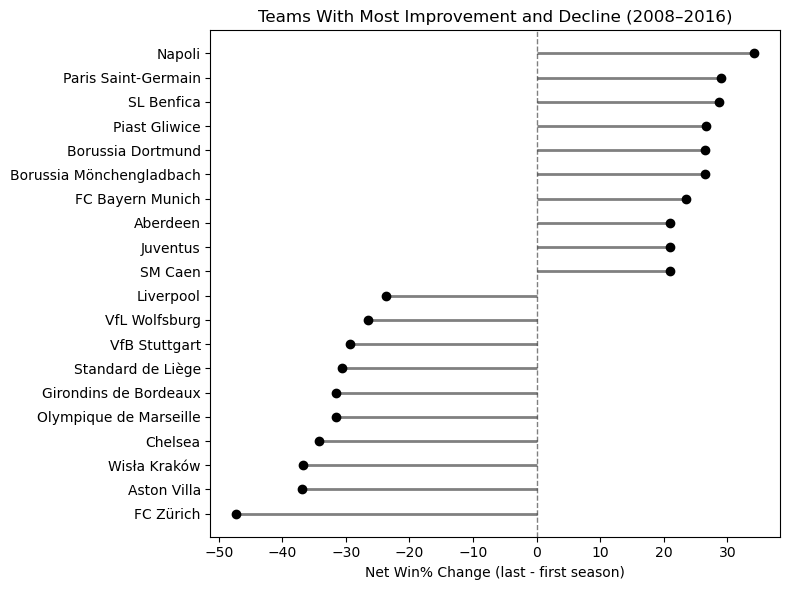

In [16]:
import matplotlib.pyplot as plt

# Sort teams by net improvement
pivot_sorted = pivot.sort_values('Net_WinPct_Change')

# Select bottom 10 and top 10 teams
num_teams = 10
short_df = pd.concat([pivot_sorted.head(num_teams), pivot_sorted.tail(num_teams)])

teams = short_df['Team'].tolist()
improvement = short_df['Net_WinPct_Change'].tolist()

plt.figure(figsize=(8, 6))
plt.hlines(y=teams, xmin=0, xmax=improvement, color='gray', lw=2)
plt.plot(improvement, teams, 'o', color='black')

plt.xlabel('Net Win% Change (last - first season)')
plt.title('Teams With Most Improvement and Decline (2008–2016)')
plt.axvline(0, color='black', lw=1, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Bar Chart: Net Win% Improvement by Team (Top 20)

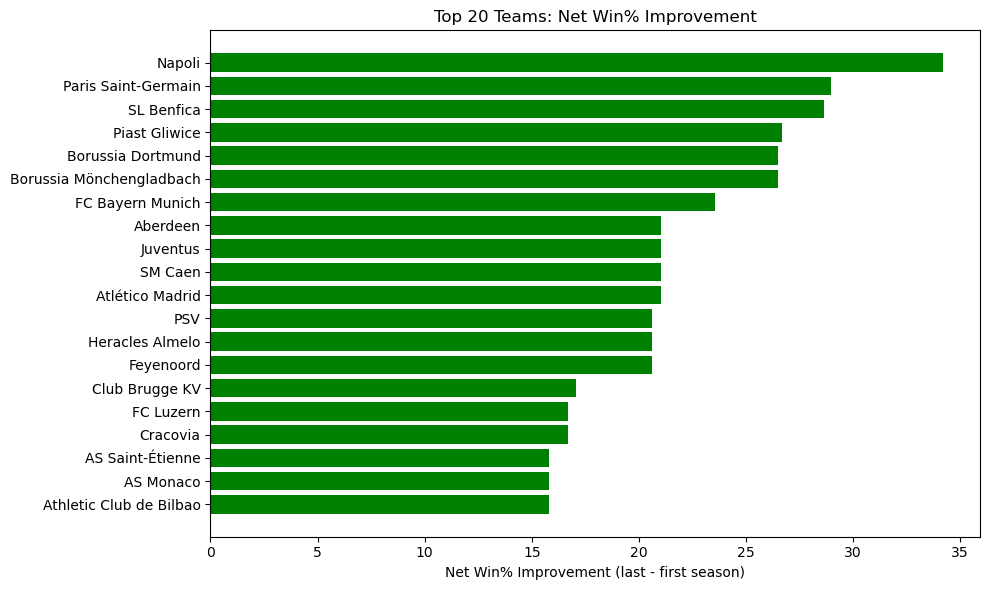

In [10]:

top20 = pivot.sort_values('Net_WinPct_Change', ascending=False).head(20)
plt.figure(figsize=(10,6))
colors = ['green' if x>0 else 'red' for x in top20['Net_WinPct_Change']]
plt.barh(top20['Team'][::-1], top20['Net_WinPct_Change'][::-1], color=colors[::-1])
plt.xlabel('Net Win% Improvement (last - first season)')
plt.title('Top 20 Teams: Net Win% Improvement')
plt.tight_layout()
plt.show()


## Boxplot: Distribution of Team Net Win% Improvement by League

/var/folders/pb/4fw095c572bb0dvz82pqpxyr0000gn/T/ipykernel_16027/873665027.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


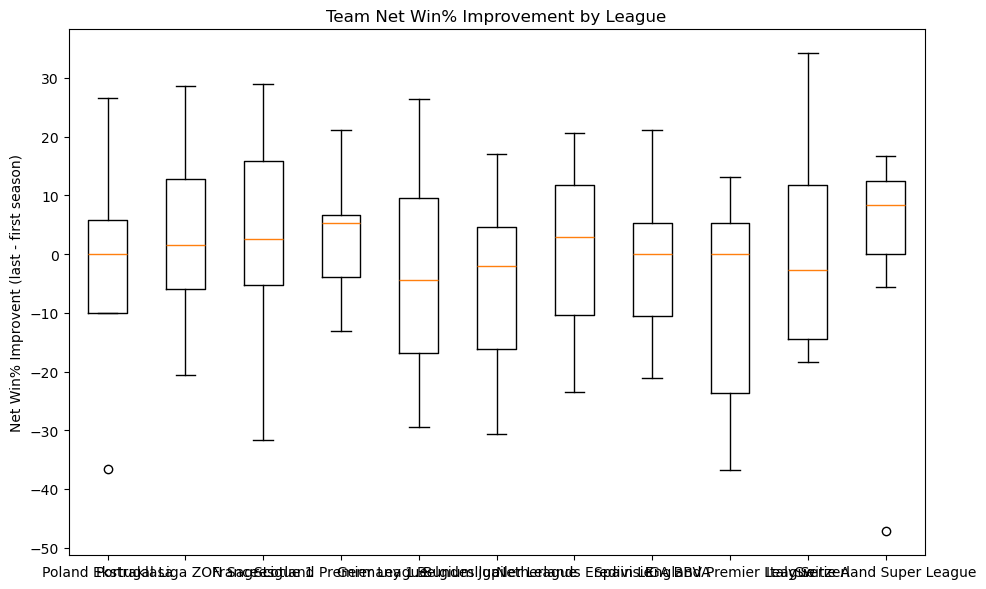

In [11]:

data = [pivot[pivot['League']==lg]['Net_WinPct_Change'] for lg in pivot['League'].unique()]
labels = pivot['League'].unique()
plt.figure(figsize=(10,6))
plt.boxplot(data, labels=labels)
plt.ylabel('Net Win% Improvent (last - first season)')
plt.title('Team Net Win% Improvement by League')
plt.tight_layout()
plt.show()


## Boxplot: Win Percentage Across Seasons
See if win% across all teams is changing over time.

/var/folders/pb/4fw095c572bb0dvz82pqpxyr0000gn/T/ipykernel_16027/1358054555.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pivot[season].dropna() for season in seasons], labels=seasons)


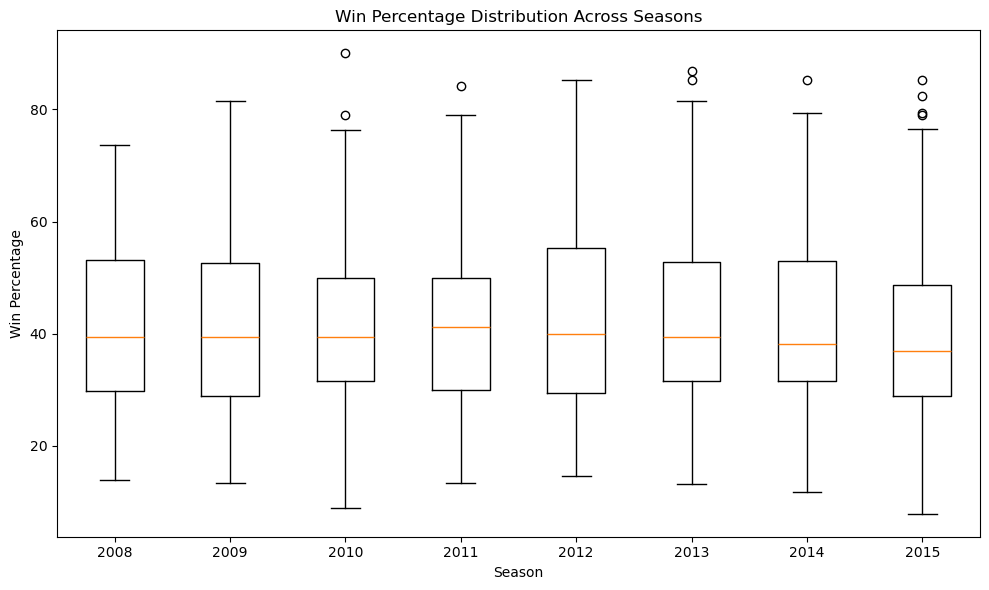

In [12]:
seasons = [c for c in pivot.columns if isinstance(c, int)]
plt.figure(figsize=(10,6))
plt.boxplot([pivot[season].dropna() for season in seasons], labels=seasons)
plt.xlabel('Season')
plt.ylabel('Win Percentage')
plt.title('Win Percentage Distribution Across Seasons')
plt.tight_layout()
plt.show()


## Line Plot: Win Percentage Over Time for Top Teams
See how top teams’ win percentages change season by season.

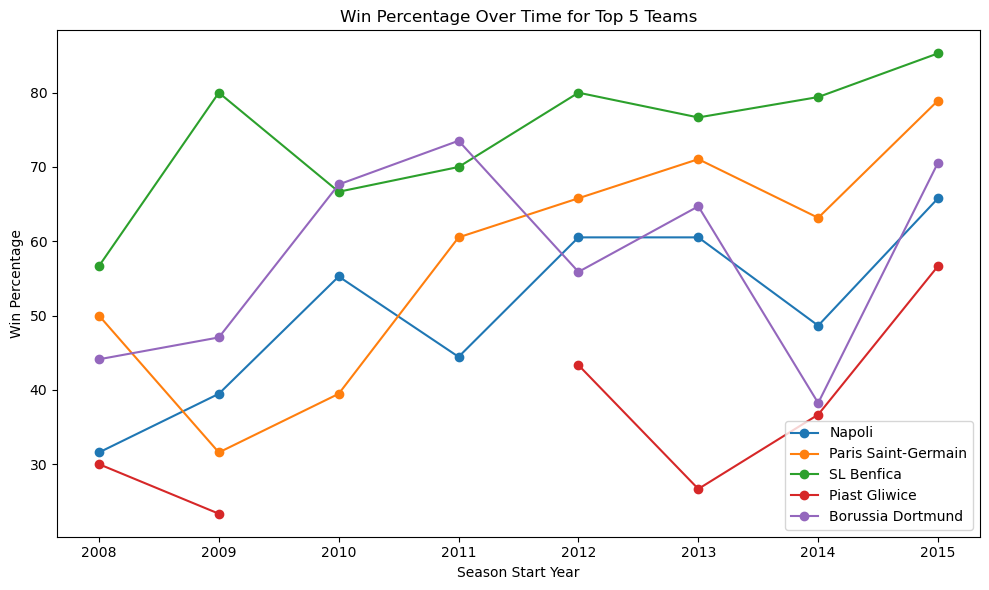

In [13]:
# Get top 5 teams by net win% change
top_teams = pivot.sort_values('Net_WinPct_Change', ascending=False)['Team'].head(5).tolist()

plt.figure(figsize=(10,6))
for team in top_teams:
    row = pivot[pivot['Team'] == team]
    # Get the years and values for this team
    seasons = [c for c in pivot.columns if isinstance(c, int)]
    plt.plot(seasons, row[seasons].values.flatten(), marker='o', label=team)
plt.xlabel('Season Start Year')
plt.ylabel('Win Percentage')
plt.title('Win Percentage Over Time for Top 5 Teams')
plt.legend()
plt.tight_layout()
plt.show()


## Heatmap: Win Percentage by Team and Season
Shows all teams’ win% for each season.

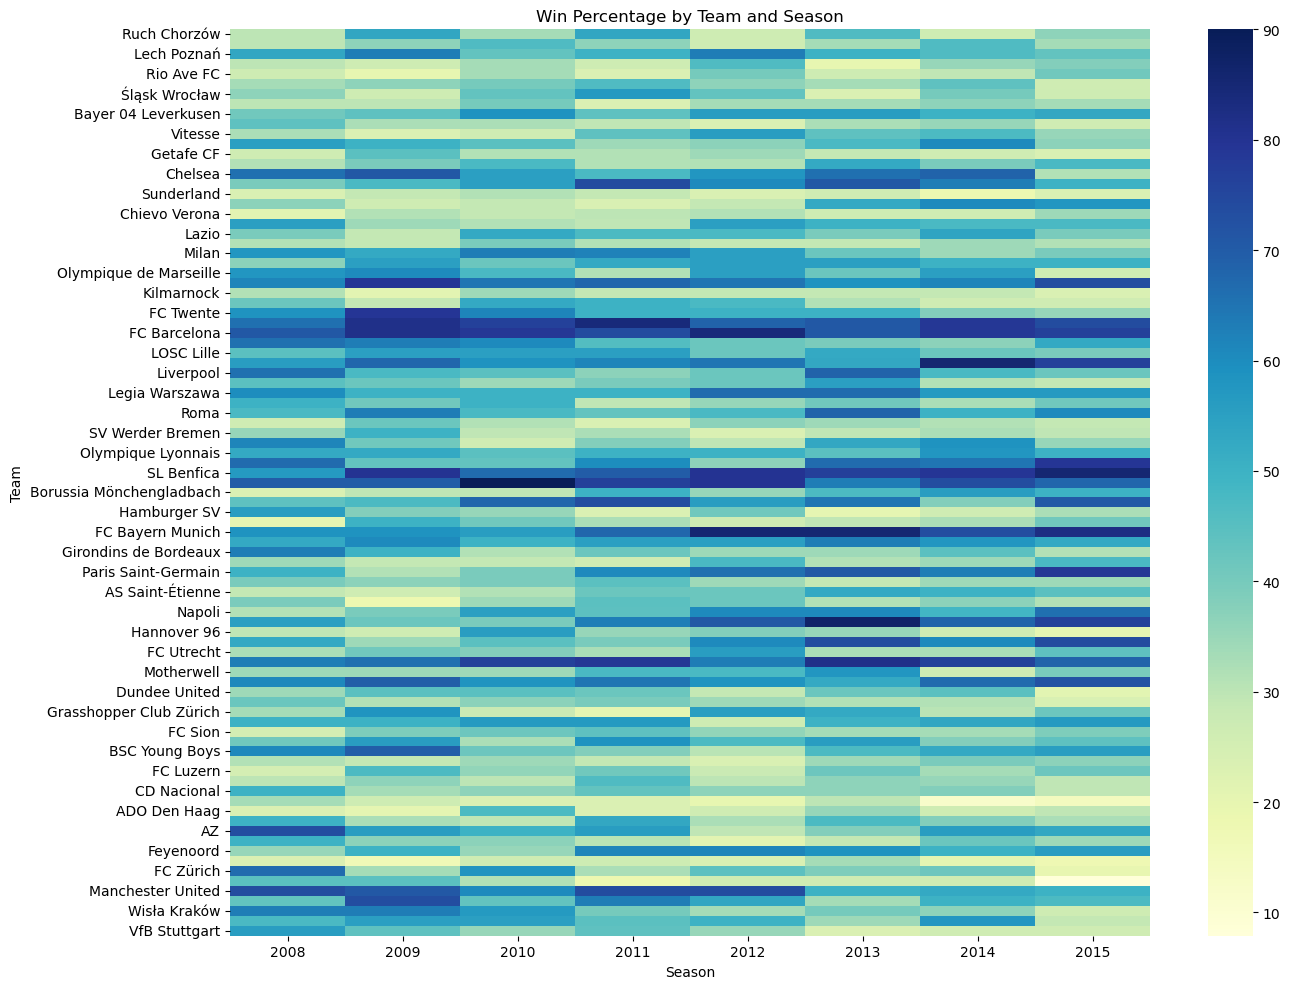

In [14]:
import seaborn as sns

hm = pivot.set_index('Team')[[c for c in pivot.columns if isinstance(c, int)]].dropna()
plt.figure(figsize=(14,10))
sns.heatmap(hm, cmap='YlGnBu', annot=False)
plt.title('Win Percentage by Team and Season')
plt.xlabel('Season')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


## Distribution Plot: Net Win% Change
Show the overall distribution of net win% change for all teams.

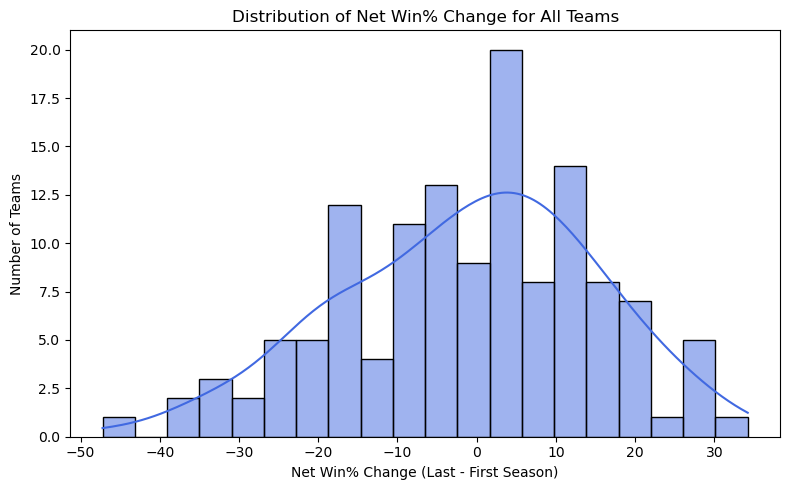

In [15]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(pivot['Net_WinPct_Change'], bins=20, kde=True, color='royalblue')
plt.title('Distribution of Net Win% Change for All Teams')
plt.xlabel('Net Win% Change (Last - First Season)')
plt.ylabel('Number of Teams')
plt.tight_layout()
plt.show()

